## Nonlinear DEGs from PerturbSeq

#### Background
- We have got a reactome similarity matrix between the perturbed genes, both in desiase and healthly.
- We know that DEGs-based similarity matrix has a statistically significant overlap with the reactome similarty matrix. 
- We want to extract knowledge from the perturbSeq dataset which would overlap with the reactome pathways.
- We already tried to build a VAE-based model learning a tree representation of every perturbation. Even though it gives promising results, it requires further tuning/refinement as the stability of the solution is low. Specifically, adjustment of the loss function and the learning concept might be needed. 

#### The Why?
- Why do we believe it is reasonable to do? DEGs are computed using t-test and have a statistically significant overlap with reactome. If we incorporate nonlinearity into DEGs in some way, we might get an even stronger result.
- Why do we want to do it? It would give us a subset of perspective relationships between genes whose exploration would potentially lead to new biological findings.

#### The How? 
- What is the simplest way? Take a binary boosting trees classifier (lgbm or catboost), and find the top useful features for every perturbation, for the model classifying into ctrl vs perturbed state.
- What is the more advanced approach? Having a similarity matrix, we can refine it by building binary classfiers for perturbation A vs perturbation B task. This would allow to exclude/highlight differences between the perturbations. The classifier performance and its feature importances would be used for the refinement. 

### Imports

In [98]:
import scanpy as scp
import pandas as pd
import numpy as np
import catboost as cb
from tqdm import tqdm
from scipy import sparse
from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from collections import Counter
import lightgbm as lgb
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import StratifiedKFold

### Magics

In [99]:
GENE_PER_CELL_BINNING = True
N_BINS = 1000
N_ITER = 50
TOP_N_GENES = 5000

### Step 0

In [100]:
adata = scp.read_h5ad('./data/Norman_2019/norman_umi_go/perturb_processed.h5ad')

In [101]:
## Following the scGPT paper, we bin the genes within cell. 

def bin_nonzero_values(arr, num_bins):
    # Filter out non-zero values
    nonzero_vals = arr[arr != 0]
    
    # Calculate bin edges
    bin_edges = np.linspace(nonzero_vals.min(), nonzero_vals.max(), num_bins)
    
    # Bin the values
    binned_values = np.zeros_like(arr)
    binned_nonzero = np.digitize(nonzero_vals, bin_edges)
    binned_values[arr != 0] = binned_nonzero
    
    return binned_values

# Example usage
arr = np.random.randint(low=0, high=100, size=100)
num_bins = 3
binned_values = bin_nonzero_values(arr, num_bins)
print(set(binned_values))

{1, 2, 3}


In [102]:
scp.pp.normalize_total(adata, exclude_highly_expressed=True)
scp.pp.log1p(adata)
scp.pp.highly_variable_genes(adata, n_top_genes=TOP_N_GENES,subset=True)

In [103]:
if GENE_PER_CELL_BINNING:
    tempy = adata.X.toarray()
    
    for c in tqdm(range(adata.X.shape[0])):
        tempy[c,:] = bin_nonzero_values(tempy[c,:], N_BINS)
    
    adata.X = sparse.csr_matrix(tempy)
    del tempy

100%|████████████████████████████████████████████████████████████| 91205/91205 [00:18<00:00, 4826.69it/s]


In [104]:
y = adata.obs.condition.values.astype(str)
X = adata.X.toarray()

In [105]:
# reducer = umap.UMAP(n_neighbors=10,verbose=True)
# embedding = reducer.fit_transform(X)

# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()
# colors = encoder.fit_transform(y)

# plt.scatter(embedding[:,0],embedding[:,1], c=colors, alpha=0.1)

### Build divergence matrix

In [106]:
# def create_folds(X, y, n_splits=10):
#     skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
#     return list(skf.split(X, y))

# def train_and_evaluate(X_train, y_train, X_test, n_stages=5, iterations=100):
#     model = CatBoostClassifier(iterations=iterations, depth=6, learning_rate=0.1, verbose=0)
#     model.fit(X_train, y_train)
    
#     staged_predictions = []
#     stage_interval = iterations // n_stages
#     for i in range(stage_interval, iterations + 1, stage_interval):
#         staged_predictions.append(model.predict(X_test, ntree_end=i))
    
#     return staged_predictions

# def main(X, y, k_folds=10, k_repeats=3, n_stages=5, iterations=100):
#     perturbations = list(set(y))
#     perturbation_index = {p: i for i, p in enumerate(perturbations)}
#     results_matrix = np.zeros((len(y), len(perturbations)))
#     evaluation_count = np.zeros(len(y))

#     fold_idx = 0
#     total_iterations = k_repeats * n_stages
#     with tqdm(total=total_iterations, desc="Evaluations") as pbar:
#         while np.any(evaluation_count < k_repeats * n_stages):
#             skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=fold_idx)
#             for train_idx, test_idx in tqdm(skf.split(X, y), total=k_folds, desc=f"Fold {fold_idx+1}"):
#                 X_train, y_train = X[train_idx], y[train_idx]
#                 X_test, y_test = X[test_idx], y[test_idx]
#                 staged_predictions = train_and_evaluate(X_train, y_train, X_test, n_stages, iterations)
                
#                 for stage_predictions in staged_predictions:
#                     for idx, (true_label, pred_label) in enumerate(zip(y_test, stage_predictions)):
#                         cell_idx = test_idx[idx]
#                         pred_label = pred_label.item()  # Convert numpy scalar to a Python scalar
#                         pred_label_index = perturbation_index[pred_label]
#                         if evaluation_count[cell_idx] < k_repeats * n_stages:
#                             results_matrix[cell_idx, pred_label_index] += 1
#                             evaluation_count[cell_idx] += 1
#                     pbar.update(1)

#                     if np.all(evaluation_count >= k_repeats * n_stages):
#                         break
            
#             fold_idx += 1

#     return results_matrix, perturbations

# # Example usage with dummy data
# # X = np.random.rand(100, 10)  # 100 cells, 10 genes
# # y = np.random.choice(['ctrl+A', 'A+ctrl', 'A+B', 'C+D'], size=100)  # Perturbations

# results_matrix, perturbations = main(X, y, k_folds=3, k_repeats=2, n_stages=10, iterations=50)
# #print(results_matrix)

In [83]:
#np.save('perturb_mtx', results_matrix)

In [84]:
results_matrix = np.load('perturb_mtx.npy')

In [85]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.99)
results_matrix_red = pca.fit_transform(results_matrix)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  )

model = LGBMClassifier(verbose=-1, n_jobs=10)
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='auc_mu',    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(1)
    ])

[1]	valid_0's auc_mu: 0.764364	valid_0's multi_logloss: 6.58296
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc_mu: 0.783759	valid_0's multi_logloss: 11.9564
[3]	valid_0's auc_mu: 0.805868	valid_0's multi_logloss: 19.4454
[4]	valid_0's auc_mu: 0.77779	valid_0's multi_logloss: 24.4433
[5]	valid_0's auc_mu: 0.7474	valid_0's multi_logloss: 27.4841
[6]	valid_0's auc_mu: 0.700679	valid_0's multi_logloss: 29.4669
[7]	valid_0's auc_mu: 0.664203	valid_0's multi_logloss: 31.1339
[8]	valid_0's auc_mu: 0.666464	valid_0's multi_logloss: 31.7017
[9]	valid_0's auc_mu: 0.659204	valid_0's multi_logloss: 31.8221
[10]	valid_0's auc_mu: 0.645206	valid_0's multi_logloss: 32.245
[11]	valid_0's auc_mu: 0.643966	valid_0's multi_logloss: 34.0051
[12]	valid_0's auc_mu: 0.642455	valid_0's multi_logloss: 33.519
[13]	valid_0's auc_mu: 0.638053	valid_0's multi_logloss: 33.6747
[14]	valid_0's auc_mu: 0.636237	valid_0's multi_logloss: 34.0078
[15]	valid_0's auc_mu: 0.634625	valid_0's 

In [62]:
# similarity_res = np.zeros(shape=(X.shape[0], N_ITER),dtype=object) 
# for i in tqdm(range(N_ITER)):
#     y_pred = model.predict_proba(X_test,num_iteration=250)
#     break

# #similarity_res[curr_idx_test, i] = y_pred

## Preparing data from the second part - first, naive without the divergences, then adding it

In [86]:
y = np.array([i.translate(str.maketrans('', '', '+ctrl')) if ('+' in i and 'ctrl' in i) else i for i in y])

In [87]:
unique_classes = np.unique(y)
classes_train, classes_test = train_test_split(unique_classes, test_size=0.2, random_state=47)

# Filter the data based on the selected classes for training and testing
curr_idx_mask = np.isin(y, classes_train)
X_train, y_train = X[curr_idx_mask], y[curr_idx_mask]
X_test, y_test = X[~curr_idx_mask], y[~curr_idx_mask]

diverg_tr = results_matrix_red[curr_idx_mask]
diverg_ts = results_matrix_red[~curr_idx_mask]

double_pert_ids_tr = []
for s in range(y_train.shape[0]):
    if '+' in y_train[s] and 'ctrl' not in y_train[s]:
        double_pert_ids_tr.append(s)

double_pert_ids_ts = []
for s in range(y_test.shape[0]):
    if '+' in y_test[s] and 'ctrl' not in y_test[s]:
        double_pert_ids_ts.append(s)


# First for training
dic = {}

p2_train = []
for dp_id in tqdm(double_pert_ids_tr):
    c1, c2 = y_train[dp_id].split('+')
    if c1 in y and c2 in y:       
        if c1 not in dic.keys():
            dic[c1] = np.where(np.array(y)==c1)[0]
        if c2 not in dic.keys():
            dic[c2] = np.where(np.array(y)==c2)[0]
        
        pos1 = np.random.choice(dic[c1])
        pos2 = np.random.choice(dic[c2])
        
        p2_train.append((pos1, pos2, dp_id))

# Then for testing
p2_test = []
dic = {}
for dp_id in tqdm(double_pert_ids_ts):
    c1, c2 = y_test[dp_id].split('+')
    
    if c1 in y and c2 in y:   
        if c1 not in dic.keys():
            dic[c1] = np.where(np.array(y)==c1)[0]        
        if c2 not in dic.keys():
            dic[c2] = np.where(np.array(y)==c2)[0]
        
        pos1 = np.random.choice(dic[c1])
        pos2 = np.random.choice(dic[c2])
        
        p2_test.append((pos1, pos2, dp_id))

100%|██████████████████████████████████████████████████████████████| 7476/7476 [00:04<00:00, 1609.65it/s]


In [88]:
X2_train = np.zeros(shape=(len(p2_train),TOP_N_GENES*2+diverg_tr.shape[1]*2))
Y2_train = np.zeros(shape=(len(p2_train),TOP_N_GENES))

for i in tqdm(range(Y2_train.shape[0])):
    X2_train[i,:TOP_N_GENES] = X[p2_train[i][0]]
    X2_train[i,TOP_N_GENES:TOP_N_GENES*2] = X[p2_train[i][1]]
    X2_train[i,TOP_N_GENES*2:diverg_tr.shape[1]+TOP_N_GENES*2] = results_matrix_red[p2_train[i][0]][0]
    X2_train[i,TOP_N_GENES*2+diverg_tr.shape[1]:] = results_matrix_red[p2_train[i][1]][0]
    Y2_train[i,:] = X_train[p2_train[i][2]]
    

X2_test = np.zeros(shape=(len(p2_test),TOP_N_GENES*2+diverg_ts.shape[1]*2))
Y2_test = np.zeros(shape=(len(p2_test),TOP_N_GENES))

for i in tqdm(range(Y2_test.shape[0])):
    X2_test[i,:TOP_N_GENES] = X[p2_test[i][0]]
    X2_test[i,TOP_N_GENES:TOP_N_GENES*2] = X[p2_test[i][1]]
    X2_test[i,TOP_N_GENES*2:diverg_ts.shape[1]+TOP_N_GENES*2] = results_matrix_red[p2_test[i][0]][0]
    X2_test[i,TOP_N_GENES*2+diverg_ts.shape[1]:] = results_matrix_red[p2_test[i][1]][0]
    
    Y2_test[i,:] = X_test[p2_test[i][2]]

100%|█████████████████████████████████████████████████████████████| 7427/7427 [00:00<00:00, 19592.56it/s]


In [89]:
X2_test.shape, X2_train.shape

((7427, 10144), (27695, 10144))

In [90]:
X2_train, X2_val, Y2_train, Y2_val = train_test_split(X2_train, Y2_train, 
                                                  test_size=0.3, 
                                                  random_state=42,
                                                  )

In [97]:
params = {'learning_rate': 0.3, 
          'depth': 4, 
          'l2_leaf_reg': 3, 
          'loss_function': 'MultiRMSE', 
          'eval_metric': 'MultiRMSE', 
          'task_type': 'CPU', 
          'iterations': 250,
          'od_type': 'Iter', 
          'boosting_type': 'Plain', 
          'bootstrap_type': 'Bernoulli', 
          'allow_const_label': True, 
         }

model = CatBoostRegressor(**params)
#model = LGBMRegressor(objective='regression_l2', metric='l2', num_iterations=50, verbose=-1)

# Train the model
model.fit(X2_train[:,:], Y2_train[:,:10], eval_set=[(X2_val[:,:], Y2_val[:,:10])], early_stopping_rounds = 50, 
                              use_best_model = True, verbose = 1)

# Make predictions on the test set
y_pred = model.predict(X2_test)

0:	learn: 179.3670647	test: 179.1546135	best: 179.1546135 (0)	total: 2.1s	remaining: 8m 43s
1:	learn: 179.2232065	test: 179.0672082	best: 179.0672082 (1)	total: 4.56s	remaining: 9m 25s
2:	learn: 179.1472540	test: 179.0564144	best: 179.0564144 (2)	total: 6.93s	remaining: 9m 30s
3:	learn: 178.9816866	test: 178.9312948	best: 178.9312948 (3)	total: 9.38s	remaining: 9m 36s
4:	learn: 178.8745401	test: 178.8661152	best: 178.8661152 (4)	total: 12.4s	remaining: 10m 8s
5:	learn: 178.7850966	test: 178.8338373	best: 178.8338373 (5)	total: 15s	remaining: 10m 11s
6:	learn: 178.7260883	test: 178.8126205	best: 178.8126205 (6)	total: 17.6s	remaining: 10m 10s
7:	learn: 178.6319899	test: 178.7610195	best: 178.7610195 (7)	total: 20s	remaining: 10m 5s
8:	learn: 178.5776093	test: 178.7404781	best: 178.7404781 (8)	total: 22.2s	remaining: 9m 54s
9:	learn: 178.5159343	test: 178.7297751	best: 178.7297751 (9)	total: 24.6s	remaining: 9m 50s
10:	learn: 178.4580169	test: 178.7233486	best: 178.7233486 (10)	total: 26

### Let's explore data and see whether classes can be distinguished manually

In [68]:
y_train

array(['TSC22D1', 'KLF1+MAP2K6', 'ctrl', ..., 'RHOXF2BB+SET', 'FOXA3',
       'CELF2'], dtype='<U15')

In [94]:
temp = X_train[y_train == 'TSC22D1']
diff_max_same = []
for i in range(temp.shape[0]-1):
    diff_max_same.append(np.max(abs(temp[i] - temp[i+1])))

In [95]:
temp2 = X_train[y_train != 'TSC22D1']
diff_max = []
for i in range(min(temp2.shape[0]-1, temp.shape[0]-1)):
    diff_max.append(np.max(abs(temp[i] - temp2[i+1])))

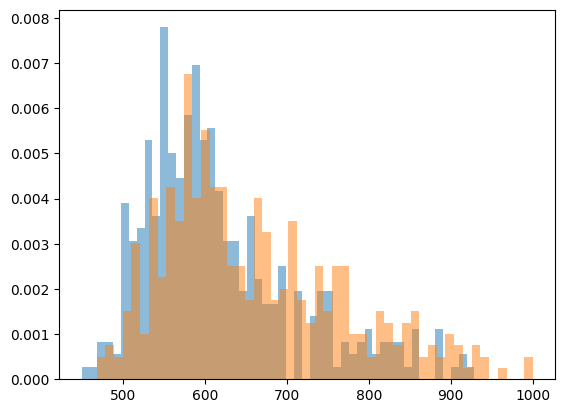

In [96]:
plt.hist(diff_max_same, bins=50,alpha=0.5,density=True)
plt.hist(diff_max, bins=50,alpha=0.5, density=True);